# **Convolutional Neural Network for Detecting Driver Drowsiness**

## Project Summary
In this project, we develop and assess a Convolutional Neural Network (CNN) designed to recognize driver drowsiness from a collection of driver photographs. We leverage a pre-trained ResNet50 backbone, adapt it for our binary classification task, and measure its effectiveness on a held-out test dataset. The key steps include:

- Importing and preparing the image data.
- Customizing a ResNet50 model for two-class output.
- Training the network with augmented data and applying early stopping.
- Assessing the model’s accuracy and errors through a confusion matrix.


## Contents

Welcome to the Driver Drowsiness Detection notebook! Here, you’ll walk through the end-to-end workflow of creating and testing a CNN to spot when drivers are sleepy. Click any link below to jump to that section:

1. [Setup & Library Imports](#setup--library-imports)  
2. [Exploratory Data Analysis](#exploratory-data-analysis)  
3. [Data Preparation](#data-preparation)  
4. [CNN Design](#cnn-design)  
5. [Model Training](#model-training)  
6. [Performance Assessment](#performance-assessment)  


## 1. Environment Setup & Library Installation

Steps to configure the workspace and install all required packages.


In [1]:
# Standard library imports
import os
import random

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Torchvision for datasets, models, and transforms
import torchvision
from torchvision import models
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision import transforms


# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 2. Dataset Exploration

Investigate the data’s organization and contents. Display example images and analyze the class distribution.  


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"


In [3]:
data_path = '/kaggle/input/drowsiness-prediction-dataset/0 FaceImages'


In [ ]:
# Gather file paths for each class
fatigue_image_paths = [
    os.path.join(data_path, 'Fatigue Subjects', fname)
    for fname in os.listdir(os.path.join(data_path, 'Fatigue Subjects'))
]
active_image_paths = [
    os.path.join(data_path, 'Active Subjects', fname)
    for fname in os.listdir(os.path.join(data_path, 'Active Subjects'))
]

# Combine and shuffle all sample paths
all_image_paths = fatigue_image_paths + active_image_paths
random.shuffle(all_image_paths)

# Determine split sizes
total_images = len(all_image_paths)
train_count = int(0.7 * total_images)
val_count = int(0.2 * total_images)
test_count = total_images - train_count - val_count

# Partition the dataset
train_paths = all_image_paths[:train_count]
val_paths = all_image_paths[train_count:train_count + val_count]
test_paths = all_image_paths[train_count + val_count:]

# Shuffle each subset independently
random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

# Display dataset counts
print(f"Total images: {total_images}")
print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Test set: {len(test_paths)} images")


Total images: 9120
Training set: 6384 images
Validation set: 1824 images
Test set: 912 images


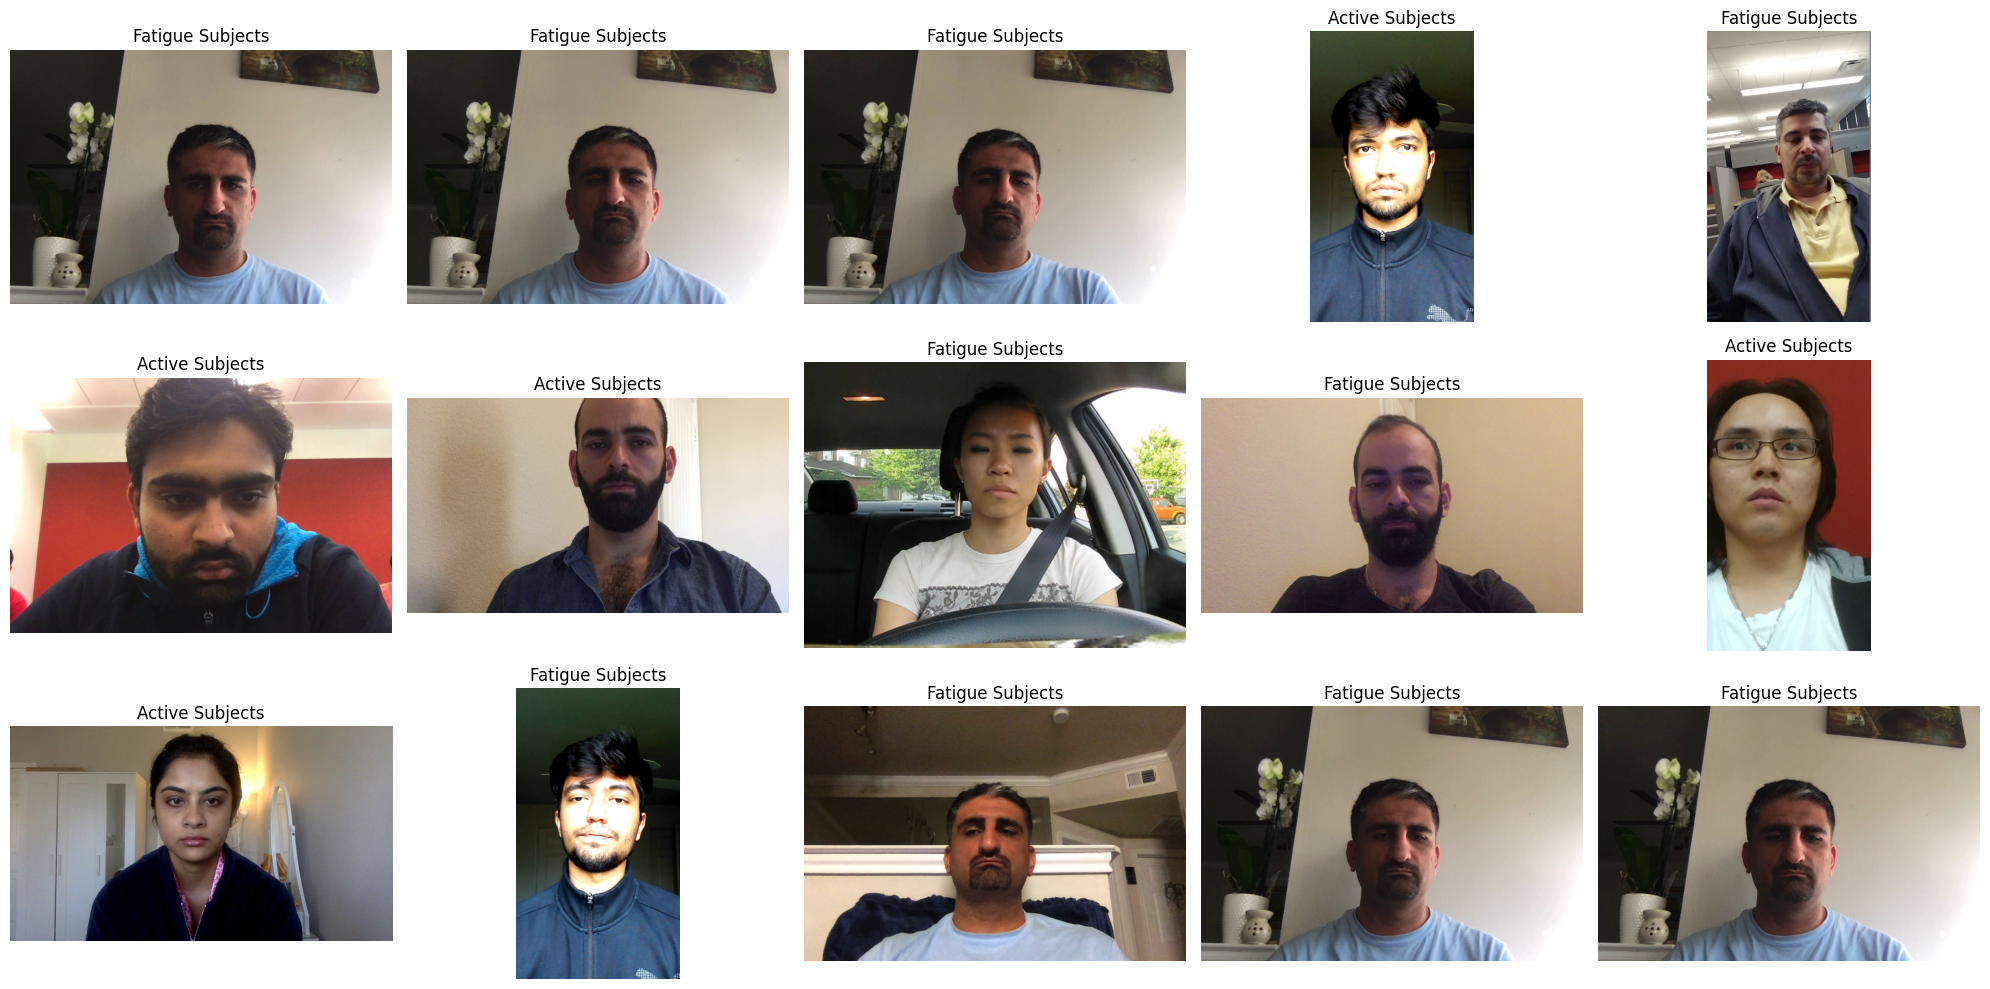

In [5]:
def get_class_label(path):
    return os.path.basename(os.path.dirname(path))



def display_labeled_images(image_paths, max_images=15):
    plt.figure(figsize=(20, 10))
    for idx, img_path in enumerate(image_paths[:max_images]):
        image = Image.open(img_path)
        class_label = get_class_label(img_path)
        plt.subplot(3, 5, idx + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_labeled_images(train_paths, max_images=15)


## 3. Preparing the Dataset

Import the image data, apply necessary preprocessing and augmentations, and set up DataLoaders for the training, validation, and test phases.


In [6]:
class CustomDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        class_name = get_class_label(path)

        if self.transform:
            img = self.transform(img)
        
        label = 0 if class_name == 'Active Subjects' else 1

        return img, label


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])


In [8]:
# Create dataset instances with associated transformations
print("Initializing training dataset...")
train_dataset = CustomDataset(paths=train_paths, transform=train_transform)

print("Initializing validation dataset...")
val_dataset = CustomDataset(paths=val_paths, transform=val_test_transform)

print("Initializing test dataset...")
test_dataset = CustomDataset(paths=test_paths, transform=val_test_transform)

# Prepare DataLoaders for each dataset
print("Setting up DataLoaders...")
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print(f"DataLoaders are ready:")
print(f" - Training batches: {len(train_loader)}")
print(f" - Validation batches: {len(val_loader)}")
print(f" - Test batches: {len(test_loader)}")


Initializing training dataset...
Initializing validation dataset...
Initializing test dataset...
Setting up DataLoaders...
DataLoaders are ready:
 - Training batches: 100
 - Validation batches: 29
 - Test batches: 15


In [9]:
def show_first_16(loader: DataLoader, split_name: str):
    """
    Grabs a single batch from `loader`, takes the first 16 images,
    unnormalizes them, and displays a 4×4 grid using matplotlib.
    """
    images, _ = next(iter(loader))  # images: [64, 3, 224, 224]
    images_16 = images[:16]         # first 16 out of the batch



    # Make a 4×4 grid (nrow=4)
    grid_tensor = make_grid(images_16, nrow=4, padding=2)  # [3, H_total, W_total]

    # Convert to H×W×3 numpy array for plotting
    grid_np = grid_tensor.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(grid_np)
    plt.axis("off")
    plt.title(f"{split_name} (First 16 after transform)")
    plt.show()



Displaying a 4×4 grid of transformed images from the TRAIN split:


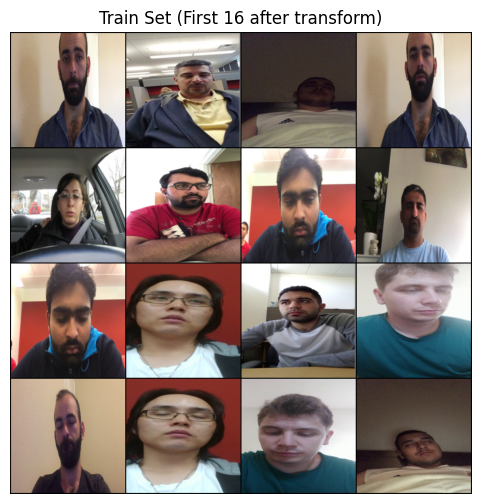

Displaying a 4×4 grid of transformed images from the VAL split:


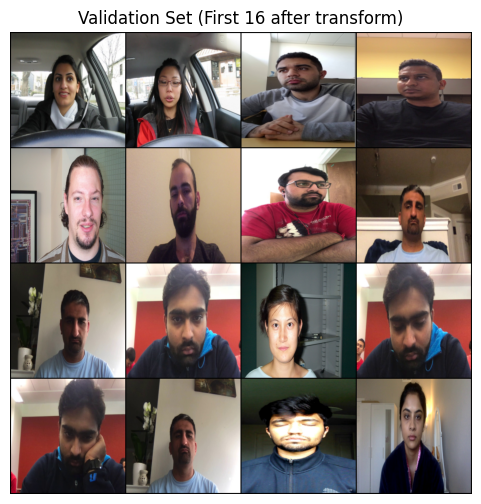

Displaying a 4×4 grid of transformed images from the TEST split:


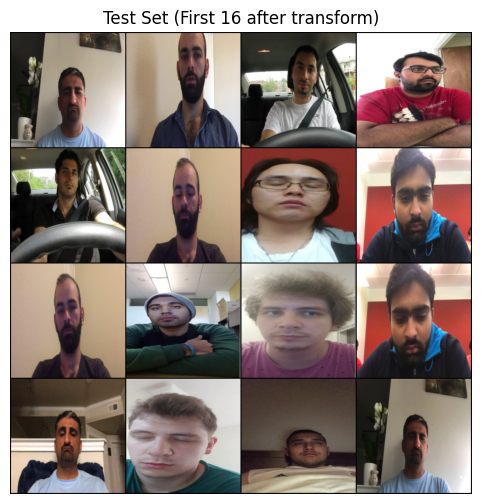

In [10]:
print("Displaying a 4×4 grid of transformed images from the TRAIN split:")
show_first_16(train_loader, split_name="Train Set")

print("Displaying a 4×4 grid of transformed images from the VAL split:")
show_first_16(val_loader, split_name="Validation Set")

print("Displaying a 4×4 grid of transformed images from the TEST split:")
show_first_16(test_loader, split_name="Test Set")

## 4. Model Architecture

A pre-trained ResNet50 model is employed, with its final layer adjusted to classify images into two categories: Drowsy and Non Drowsy.


In [20]:
model = models.resnet50(weights='IMAGENET1K_V2')

# Disable gradient updates for all layers
for param in model.parameters():
    param.requires_grad = False

# Enable training for the last `n` layers only
n = 3
total_children = len(list(model.children()))
for idx, child in enumerate(model.children(), start=1):
    if idx > total_children - n:
        for param in child.parameters():
            param.requires_grad = True

# Modify the fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 2)
)

# Move model to the selected device
model = model.to(device)



## 5. Model Training

Set up the training loop and incorporate early stopping to avoid overfitting.


In [21]:
class Trainer:
    def __init__(self, model, criterion, optimizer, device, patience=5, checkpoint_path='best_model.pth'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.patience = patience
        self.checkpoint_path = checkpoint_path
        
        self.best_val_loss = float('inf')
        self.counter = 0

    def train_epoch(self, train_loader, epoch, num_epochs):
        self.model.train()
        running_loss = 0.0
        total_step = len(train_loader)

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)

            outputs = self.model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = self.criterion(outputs, labels)
            running_loss += loss.item()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if (i + 1) % 100 == 0 or (i + 1) == total_step:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Train Loss: {running_loss / (i + 1):.4f}')

        avg_loss = running_loss / total_step
        return avg_loss

    def evaluate(self, data_loader, dataset_type='Validation'):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = len(data_loader.dataset)

        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(data_loader)
        accuracy = 100 * correct / total
        print(f'{dataset_type} Accuracy: {accuracy:.2f}% | {dataset_type} Loss: {avg_loss:.4f}')
        return avg_loss, accuracy

    def checkpoint_and_early_stop(self, avg_val_loss):
        if avg_val_loss < self.best_val_loss:
            self.best_val_loss = avg_val_loss
            self.counter = 0
            torch.save(self.model, self.checkpoint_path)
            print(f"New best model saved with validation loss: {avg_val_loss:.4f}")
            return False  # Do not stop

        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                return True  # Stop training

        return False  # Do not stop



In [22]:
total_epochs = 6
early_stop_patience = 3
lowest_val_loss = float('inf')
stopping_counter = 0
lr = 1e-4
training_loss_history = []
validation_loss_history = []


In [23]:
# Determine the total number of training steps
total_steps = len(train_loader)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, model.parameters()),
    lr=lr
)



In [24]:
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    checkpoint_path='model.pth'
)

train_losses = []
val_losses = []

for epoch in range(total_epochs):
    # Train for one epoch
    avg_train_loss = trainer.train_epoch(train_loader, epoch, total_epochs)
    train_losses.append(avg_train_loss)

    # Evaluate on validation set
    avg_val_loss, _ = trainer.evaluate(val_loader, dataset_type='Validation')
    val_losses.append(avg_val_loss)

    # Check early stopping
    should_stop = trainer.checkpoint_and_early_stop(avg_val_loss)
    if should_stop:
        break

    

Epoch [1/6], Step [100/100], Train Loss: 0.3402
Validation Accuracy: 92.82% | Validation Loss: 0.1801
New best model saved with validation loss: 0.1801
Epoch [2/6], Step [100/100], Train Loss: 0.1348
Validation Accuracy: 93.26% | Validation Loss: 0.1972
Epoch [3/6], Step [100/100], Train Loss: 0.0903
Validation Accuracy: 94.90% | Validation Loss: 0.1349
New best model saved with validation loss: 0.1349
Epoch [4/6], Step [100/100], Train Loss: 0.0647
Validation Accuracy: 94.63% | Validation Loss: 0.1511
Epoch [5/6], Step [100/100], Train Loss: 0.0566
Validation Accuracy: 93.86% | Validation Loss: 0.1618
Epoch [6/6], Step [100/100], Train Loss: 0.0443
Validation Accuracy: 94.79% | Validation Loss: 0.1630


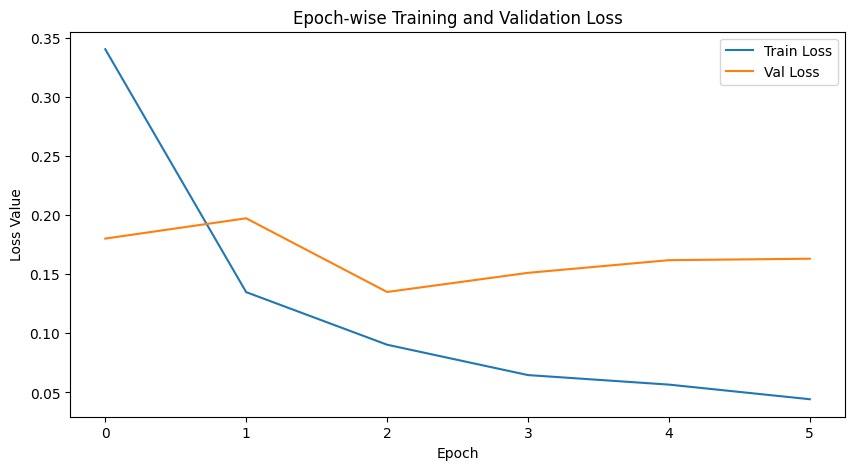

In [25]:
# Visualize training vs. validation loss across epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Epoch-wise Training and Validation Loss')
plt.legend()
plt.show()


## 6. Evaluating the Model
evaluate the model's performance and visualize the confusion matrix.

In [26]:
class Evaluator:
    def __init__(self, model, criterion, device):
        self.model = model
        self.criterion = criterion
        self.device = device

    def evaluate(self, data_loader, dataset_type='Validation'):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = len(data_loader.dataset)

        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(data_loader)
        accuracy = 100 * correct / total
        print(f'{dataset_type} Accuracy: {accuracy:.2f}% | {dataset_type} Loss: {avg_loss:.4f}')
        return avg_loss, accuracy

    def plot_confusion_matrix(self, data_loader, class_labels=['Drowsy', 'Non Drowsy']):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()


Validation Accuracy: 94.79% | Validation Loss: 0.1630
Test Accuracy: 96.05% | Test Loss: 0.1301


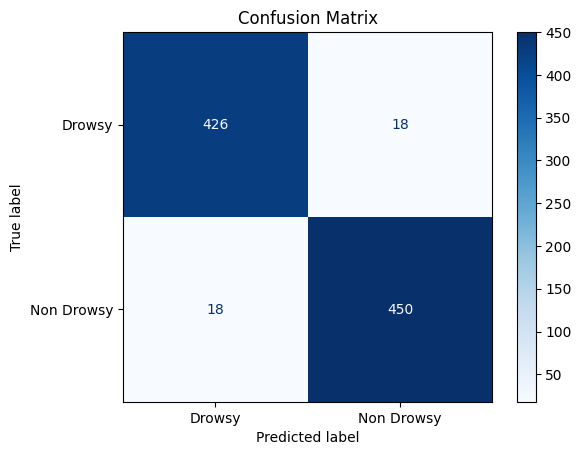

In [27]:
evaluator = Evaluator(model, criterion, device)

# Evaluate on validation and test sets
val_loss, val_accuracy = evaluator.evaluate(val_loader, dataset_type='Validation')
test_loss, test_accuracy = evaluator.evaluate(test_loader, dataset_type='Test')

# Plot the confusion matrix for test set
evaluator.plot_confusion_matrix(test_loader)


![Thank You Image](https://www.proposify.com/hs-fs/hubfs/Imported_Blog_Media/blog-2020-04-07-how_to_say_thank_you_in_business-Apr-09-2024-05-22-03-0706-PM.png?width=760&height=550&name=blog-2020-04-07-how_to_say_thank_you_in_business-Apr-09-2024-05-22-03-0706-PM.png)
